# Trader Performance vs Market Sentiment Analysis
## Data Science Intern Assignment - Primetrade.ai

**Author:** Rohit Khanra  
**Date:** February 4, 2026  

### Objective
Analyze how market sentiment (Fear/Greed) relates to trader behavior and performance on Hyperliquid to uncover patterns that could inform smarter trading strategies.

## Setup and Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## Part A: Data Preparation

### 1. Load Datasets

In [2]:
# Load Bitcoin Market Sentiment data
# NOTE: Download the file from the Google Drive link provided and update the path
sentiment_df = pd.read_csv('/content/sample_data/fear_greed_index.csv')  # Update path as needed

print("=" * 60)
print("BITCOIN MARKET SENTIMENT DATA")
print("=" * 60)
print(f"\nShape: {sentiment_df.shape}")
print(f"Rows: {sentiment_df.shape[0]}")
print(f"Columns: {sentiment_df.shape[1]}")
print(f"\nColumn names: {list(sentiment_df.columns)}")
print(f"\nData types:\n{sentiment_df.dtypes}")
print(f"\nMissing values:\n{sentiment_df.isnull().sum()}")
print(f"\nDuplicate rows: {sentiment_df.duplicated().sum()}")
print(f"\nFirst few rows:")
print(sentiment_df.head())
print(f"\nSentiment distribution:")
print(sentiment_df.iloc[:, 1].value_counts())  # Second column is sentiment

BITCOIN MARKET SENTIMENT DATA

Shape: (2644, 4)
Rows: 2644
Columns: 4

Column names: ['timestamp', 'value', 'classification', 'date']

Data types:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows: 0

First few rows:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Sentiment distribution:
value
50    70
24    61
27    60
72    60
20    58
      ..
87     4
89     3
7      2
6      2
5      1
Name: count, Length: 90, dtype: int64


In [3]:
# Load Historical Trader Data
# NOTE: Download the file from the Google Drive link provided and update the path
trader_df = pd.read_csv('/content/sample_data/historical_data.csv')  # Update path as needed

print("=" * 60)
print("HISTORICAL TRADER DATA")
print("=" * 60)
print(f"\nShape: {trader_df.shape}")
print(f"Rows: {trader_df.shape[0]}")
print(f"Columns: {trader_df.shape[1]}")
print(f"\nColumn names: {list(trader_df.columns)}")
print(f"\nData types:\n{trader_df.dtypes}")
print(f"\nMissing values:\n{trader_df.isnull().sum()}")
print(f"\nMissing values (%):\n{(trader_df.isnull().sum() / len(trader_df) * 100).round(2)}")
print(f"\nDuplicate rows: {trader_df.duplicated().sum()}")
print(f"\nFirst few rows:")
print(trader_df.head(10))

HISTORICAL TRADER DATA

Shape: (211224, 16)
Rows: 211224
Columns: 16

Column names: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Data types:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID              int64
Crossed                bool
Fee                 float64
Trade ID            float64
Timestamp           float64
dtype: object

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL     

### 2. Data Cleaning and Preprocessing

In [5]:
# Clean sentiment data
sentiment_clean = sentiment_df.copy()

# Remove duplicates
sentiment_clean = sentiment_clean.drop_duplicates()

# Convert the existing 'date' column to datetime
sentiment_clean['date'] = pd.to_datetime(sentiment_clean['date'])

# Select only the 'date' and 'classification' columns and rename 'classification' to 'sentiment'
sentiment_clean = sentiment_clean[['date', 'classification']].rename(columns={'classification': 'sentiment'})

# Remove any remaining missing values
sentiment_clean = sentiment_clean.dropna()

print(f"Sentiment data after cleaning: {sentiment_clean.shape}")
print(f"Date range: {sentiment_clean['date'].min()} to {sentiment_clean['date'].max()}")

Sentiment data after cleaning: (2644, 2)
Date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [10]:
# Clean trader data
trader_clean = trader_df.copy()

# Rename columns to match expected lowercase format and correct names for processing
trader_clean = trader_clean.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',  # Assuming 'Coin' should be 'symbol'
    'Timestamp IST': 'time', # Use 'Timestamp IST' as the primary time column for conversion
    'Closed PnL': 'closedPnl',
    'Size Tokens': 'size',
    'Side': 'side' # Rename 'Side' to 'side' for consistency
})

# Remove duplicates
trader_clean = trader_clean.drop_duplicates()

# Convert time column to datetime with explicit format
trader_clean['time'] = pd.to_datetime(trader_clean['time'], format='%d-%m-%Y %H:%M')

# Create date column for merging
trader_clean['date'] = trader_clean['time'].dt.date
trader_clean['date'] = pd.to_datetime(trader_clean['date'])

print(f"Trader data after cleaning: {trader_clean.shape}")
print(f"Date range: {trader_clean['date'].min()} to {trader_clean['date'].max()}")
print(f"\nUnique accounts: {trader_clean['account'].nunique()}")
print(f"Unique symbols: {trader_clean['symbol'].nunique()}")

Trader data after cleaning: (211224, 17)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

Unique accounts: 32
Unique symbols: 246


### 3. Create Key Metrics

In [11]:
# Calculate daily metrics per trader
daily_metrics = trader_clean.groupby(['account', 'date']).agg({
    'closedPnl': ['sum', 'mean', 'std', 'count'],  # PnL metrics
    'size': ['sum', 'mean'],  # Trade size
    'side': lambda x: (x == 'BUY').sum(),  # Count of buy orders (long) - assuming 'BUY' is the value for buy side
}).reset_index()

# Flatten column names
daily_metrics.columns = ['account', 'date', 'daily_pnl', 'avg_pnl_per_trade', 'pnl_std',
                         'num_trades', 'total_size', 'avg_trade_size', 'long_count']

# Calculate additional metrics
daily_metrics['short_count'] = daily_metrics['num_trades'] - daily_metrics['long_count']
# Handle potential division by zero if num_trades is 0
daily_metrics['long_short_ratio'] = daily_metrics.apply(
    lambda row: row['long_count'] / row['num_trades'] if row['num_trades'] != 0 else 0,
    axis=1
)

# Calculate win rate (trades with positive PnL)
wins = trader_clean[trader_clean['closedPnl'] > 0].groupby(['account', 'date']).size().reset_index(name='winning_trades')
daily_metrics = daily_metrics.merge(wins, on=['account', 'date'], how='left')
daily_metrics['winning_trades'] = daily_metrics['winning_trades'].fillna(0)
daily_metrics['win_rate'] = daily_metrics['winning_trades'] / daily_metrics['num_trades']

# Handle division by zero and NaN
daily_metrics['win_rate'] = daily_metrics['win_rate'].fillna(0)
daily_metrics['pnl_std'] = daily_metrics['pnl_std'].fillna(0)

print(f"Daily metrics shape: {daily_metrics.shape}")
print(daily_metrics.head())
print(f"\nMetrics summary:")
print(daily_metrics.describe())

Daily metrics shape: (2341, 13)
                                      account       date  daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22   -21227.0   
4  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-26     1603.1   

   avg_pnl_per_trade      pnl_std  num_trades  total_size  avg_trade_size  \
0           0.000000     0.000000         177       281.0        1.587571   
1           0.000000     0.000000          68      1100.0       16.176471   
2           0.000000     0.000000          40       300.0        7.500000   
3       -1768.916667  1526.178379          12       100.0        8.333333   
4          59.374074   172.316814          27      2000.0       74.074074   

   long_count  short_count  long_short_ratio  winning_trades  win_rate  
0    

### 4. Merge Datasets by Date

In [16]:
# Merge daily metrics with sentiment
merged_data = daily_metrics.merge(sentiment_clean, on='date', how='inner')

print(f"Merged dataset shape: {merged_data.shape}")
print(f"\nDate range after merge: {merged_data['date'].min()} to {merged_data['date'].max()}")
print(f"\nSentiment distribution in merged data:")
print(merged_data['sentiment'].value_counts())
print(f"\nMissing values in merged data:")
print(merged_data.isnull().sum())

print(merged_data.head())

Merged dataset shape: (2340, 14)

Date range after merge: 2023-05-01 00:00:00 to 2025-05-01 00:00:00

Sentiment distribution in merged data:
sentiment
Greed            648
Fear             630
Extreme Greed    526
Neutral          376
Extreme Fear     160
Name: count, dtype: int64

Missing values in merged data:
account              0
date                 0
daily_pnl            0
avg_pnl_per_trade    0
pnl_std              0
num_trades           0
total_size           0
avg_trade_size       0
long_count           0
short_count          0
long_short_ratio     0
winning_trades       0
win_rate             0
sentiment            0
dtype: int64
                                      account       date  daily_pnl  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-11        0.0   
1  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-17        0.0   
2  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-18        0.0   
3  0x083384f897ee0f19899168e3b1bec365f52a9012 2024-11-22   -21227.0

## Part B: Analysis

### Question 1: Does performance differ between Fear vs Greed days?

In [13]:
# Compare performance metrics by sentiment
performance_by_sentiment = merged_data.groupby('sentiment').agg({
    'daily_pnl': ['mean', 'median', 'std'],
    'win_rate': ['mean', 'median'],
    'pnl_std': ['mean'],  # Proxy for drawdown/volatility
    'account': 'count'
}).round(4)

print("=" * 60)
print("PERFORMANCE COMPARISON: FEAR vs GREED")
print("=" * 60)
print(performance_by_sentiment)

# Statistical test (t-test)
fear_pnl = merged_data[merged_data['sentiment'] == 'Fear']['daily_pnl']
greed_pnl = merged_data[merged_data['sentiment'] == 'Greed']['daily_pnl']

t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl, nan_policy='omit')
print(f"\nT-test for daily PnL:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

PERFORMANCE COMPARISON: FEAR vs GREED
               daily_pnl                       win_rate           pnl_std  \
                    mean    median         std     mean  median      mean   
sentiment                                                                   
Extreme Fear   4619.4391  218.3774  29534.8392   0.3297  0.3077  558.4599   
Extreme Greed  5161.9226  418.3199  27496.8638   0.3864  0.3571  254.7001   
Fear           5328.8182  107.8925  31659.7715   0.3640  0.3153  260.4289   
Greed          3318.1007  158.2149  30599.0402   0.3436  0.2892  245.9225   
Neutral        3438.6188  167.5517  17447.8636   0.3554  0.3211  207.5776   

              account  
                count  
sentiment              
Extreme Fear      160  
Extreme Greed     526  
Fear              630  
Greed             648  
Neutral           376  

T-test for daily PnL:
T-statistic: 1.1546
P-value: 0.2485
Significant difference: No (α=0.05)


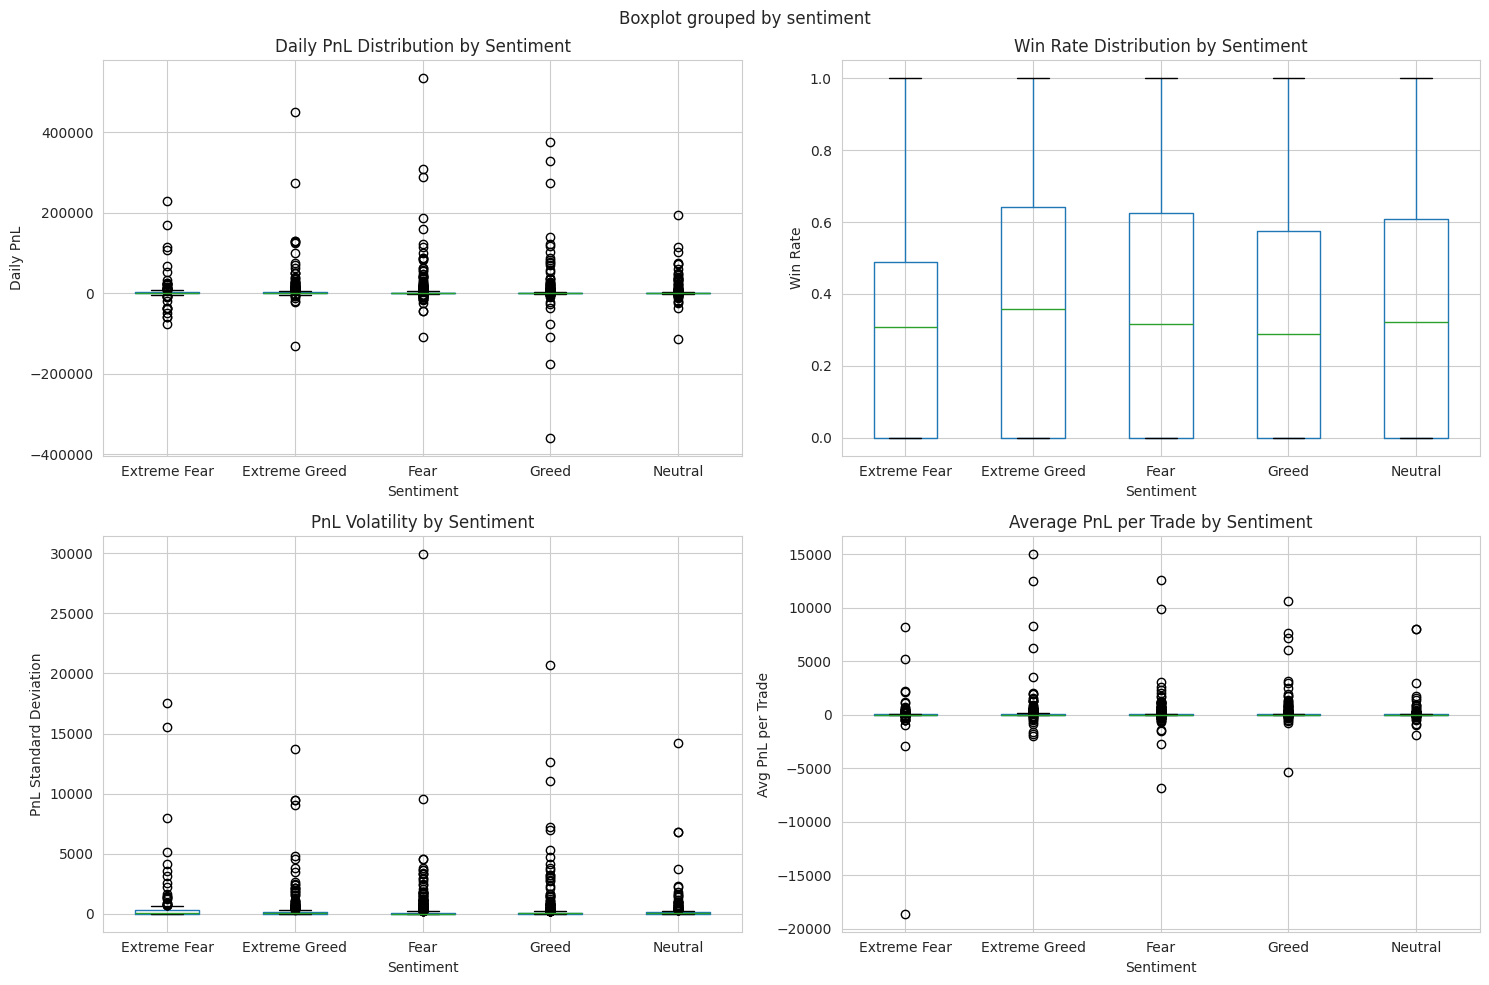

Chart saved as 'performance_by_sentiment.png'


In [14]:
# Visualization: Performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily PnL distribution
merged_data.boxplot(column='daily_pnl', by='sentiment', ax=axes[0, 0])
axes[0, 0].set_title('Daily PnL Distribution by Sentiment')
axes[0, 0].set_ylabel('Daily PnL')
axes[0, 0].set_xlabel('Sentiment')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# Win rate distribution
merged_data.boxplot(column='win_rate', by='sentiment', ax=axes[0, 1])
axes[0, 1].set_title('Win Rate Distribution by Sentiment')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].set_xlabel('Sentiment')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# PnL volatility (drawdown proxy)
merged_data.boxplot(column='pnl_std', by='sentiment', ax=axes[1, 0])
axes[1, 0].set_title('PnL Volatility by Sentiment')
axes[1, 0].set_ylabel('PnL Standard Deviation')
axes[1, 0].set_xlabel('Sentiment')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Average PnL per trade
merged_data.boxplot(column='avg_pnl_per_trade', by='sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Average PnL per Trade by Sentiment')
axes[1, 1].set_ylabel('Avg PnL per Trade')
axes[1, 1].set_xlabel('Sentiment')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('performance_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'performance_by_sentiment.png'")

### Question 2: Do traders change behavior based on sentiment?

In [17]:
# Compare behavior metrics by sentiment
behavior_by_sentiment = merged_data.groupby('sentiment').agg({
    'num_trades': ['mean', 'median'],
    'long_short_ratio': ['mean', 'median'],
    'avg_trade_size': ['mean', 'median'],
    'total_size': ['mean', 'median']
}).round(4)

print("=" * 60)
print("BEHAVIOR COMPARISON: FEAR vs GREED")
print("=" * 60)
print(behavior_by_sentiment)

# Statistical tests for key behavioral metrics
print("\n" + "=" * 60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("=" * 60)

metrics_to_test = ['num_trades', 'long_short_ratio', 'avg_trade_size']
for metric in metrics_to_test:
    fear_data = merged_data[merged_data['sentiment'] == 'Fear'][metric]
    greed_data = merged_data[merged_data['sentiment'] == 'Greed'][metric]
    t_stat, p_value = stats.ttest_ind(fear_data, greed_data, nan_policy='omit')
    print(f"\n{metric}:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

BEHAVIOR COMPARISON: FEAR vs GREED
              num_trades        long_short_ratio         avg_trade_size  \
                    mean median             mean  median           mean   
sentiment                                                                 
Extreme Fear    133.7500   50.5           0.5315  0.4955      2260.7651   
Extreme Greed    76.0304   31.5           0.4731  0.4689     12979.7650   
Fear             98.1540   26.0           0.5190  0.5144      6465.7307   
Greed            77.6281   25.0           0.4716  0.4651      4779.7987   
Neutral         100.2287   29.5           0.4724  0.4902      6104.8836   

                          total_size              
                 median         mean      median  
sentiment                                         
Extreme Fear   192.4642  224150.7314  12272.5800  
Extreme Greed  172.7911  671532.2633   8633.8280  
Fear           139.4045  293739.6727   6092.3700  
Greed          172.6362  366041.8705   6155.3037  
Neutral

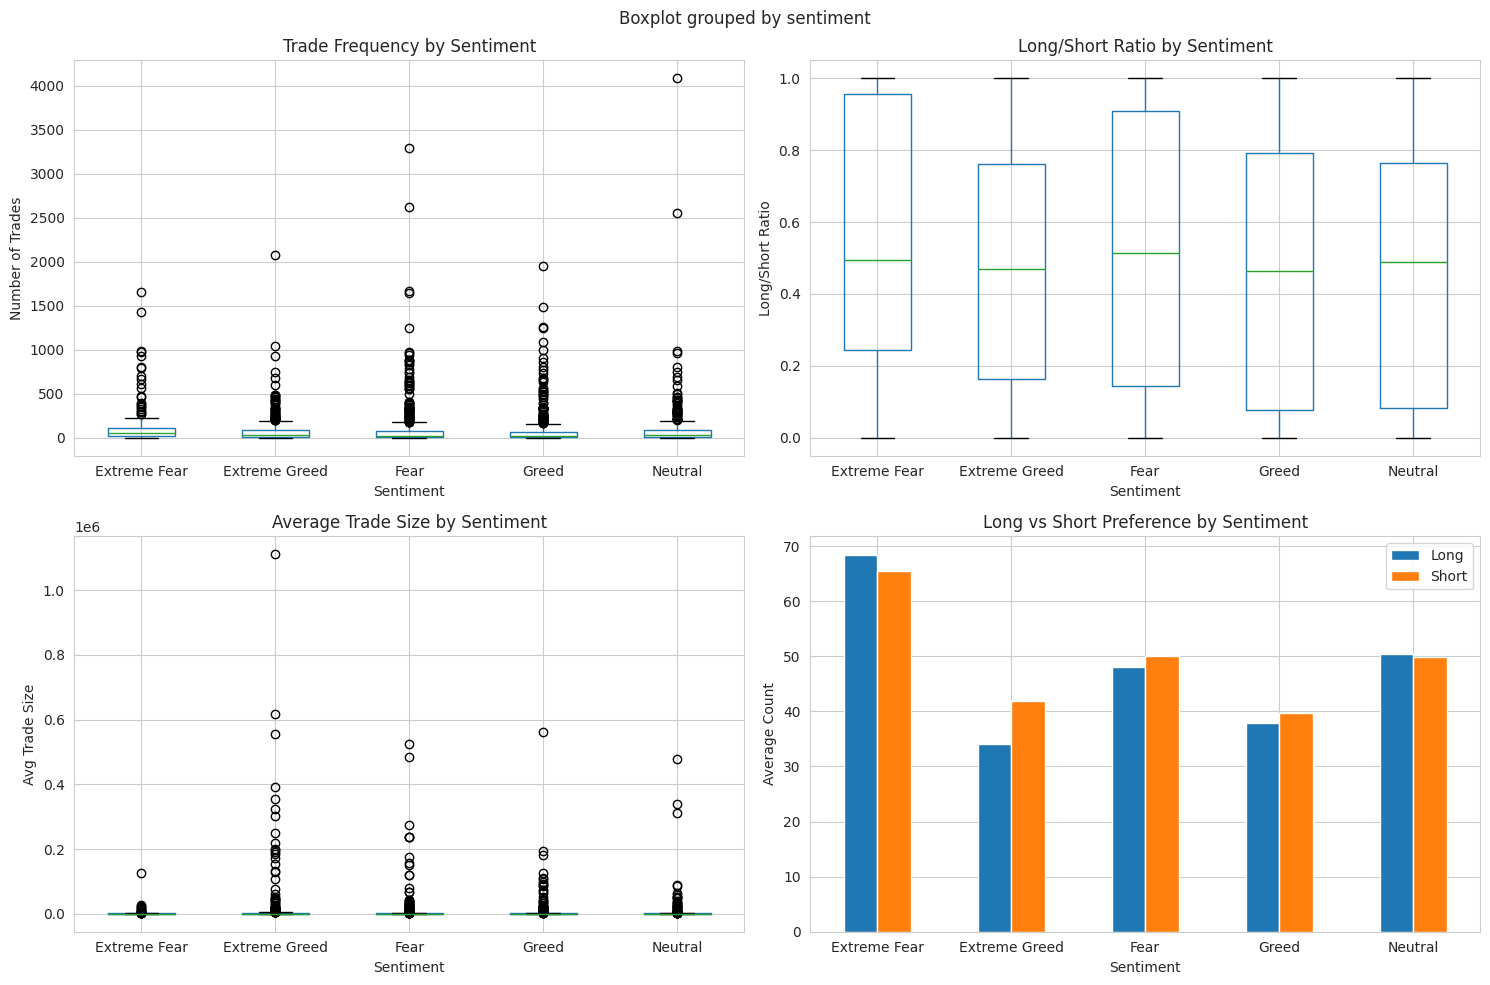

Chart saved as 'behavior_by_sentiment.png'


In [20]:
# Visualization: Behavior comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Adjusted to 2x2 since one row is removed

# Trade frequency
merged_data.boxplot(column='num_trades', by='sentiment', ax=axes[0, 0])
axes[0, 0].set_title('Trade Frequency by Sentiment')
axes[0, 0].set_ylabel('Number of Trades')
axes[0, 0].set_xlabel('Sentiment')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# Long/Short ratio
merged_data.boxplot(column='long_short_ratio', by='sentiment', ax=axes[0, 1])
axes[0, 1].set_title('Long/Short Ratio by Sentiment')
axes[0, 1].set_ylabel('Long/Short Ratio')
axes[0, 1].set_xlabel('Sentiment')
plt.sca(axes[0, 1])
plt.xticks(rotation=0)

# Position size
merged_data.boxplot(column='avg_trade_size', by='sentiment', ax=axes[1, 0])
axes[1, 0].set_title('Average Trade Size by Sentiment')
axes[1, 0].set_ylabel('Avg Trade Size')
axes[1, 0].set_xlabel('Sentiment')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# Long vs Short preference
long_short_data = merged_data.groupby('sentiment')[['long_count', 'short_count']].mean()
long_short_data.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Long vs Short Preference by Sentiment')
axes[1, 1].set_ylabel('Average Count')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].legend(['Long', 'Short'])
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('behavior_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'behavior_by_sentiment.png'")

### Question 3: Trader Segmentation

In [19]:
# Create trader-level aggregations for segmentation
trader_profiles = merged_data.groupby('account').agg({
    'daily_pnl': ['mean', 'std', 'sum'],
    'num_trades': ['sum', 'mean'],
    'win_rate': 'mean',
    'date': 'count'  # Trading days
}).reset_index()

trader_profiles.columns = ['account', 'avg_daily_pnl', 'pnl_volatility', 'total_pnl',
                           'total_trades', 'avg_trades_per_day', 'avg_win_rate', 'trading_days']

# Calculate consistency metric (coefficient of variation)
trader_profiles['pnl_consistency'] = trader_profiles['pnl_volatility'] / (trader_profiles['avg_daily_pnl'].abs() + 1e-6)

print(f"Trader profiles created: {trader_profiles.shape}")
print(trader_profiles.head())
print(trader_profiles.describe())

Trader profiles created: (32, 9)
                                      account  avg_daily_pnl  pnl_volatility  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   66676.242499   150401.797346   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd     920.871548     3603.042291   
2  0x271b280974205ca63b716753467d5a371de622ab   -5869.682610    33420.410014   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4     817.684040     2993.284702   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd    2444.318913     4867.743469   

      total_pnl  total_trades  avg_trades_per_day  avg_win_rate  trading_days  \
0  1.600230e+06          3818          159.083333      0.352333            24   
1  4.788532e+04          7280          140.000000      0.397134            52   
2 -7.043619e+04          3809          317.416667      0.379952            12   
3  1.324648e+05         13311           82.166667      0.452509           162   
4  1.686580e+05          3239           46.942029      0.498708            69   


In [25]:
# Segment 2: Frequent vs Infrequent Traders
trade_freq_median = trader_profiles['avg_trades_per_day'].median()
trader_profiles['frequency_segment'] = trader_profiles['avg_trades_per_day'].apply(
    lambda x: 'Frequent Trader' if x > trade_freq_median else 'Infrequent Trader'
)

print("=" * 60)
print("SEGMENT 2: FREQUENT vs INFREQUENT TRADERS")
print("=" * 60)
print(f"Trade frequency threshold: {trade_freq_median:.2f} trades/day")

frequency_comparison = trader_profiles.groupby('frequency_segment').agg({
    'avg_daily_pnl': ['mean', 'median'],
    'avg_win_rate': ['mean', 'median'],
    'pnl_consistency': ['mean', 'median'],
    'account': 'count'
}).round(4)

print(frequency_comparison)

# Initialize merged_with_segments with merged_data since leverage segment was skipped
merged_with_segments = merged_data.copy()

# Merge frequency segment
merged_with_segments = merged_with_segments.merge(
    trader_profiles[['account', 'frequency_segment']],
    on='account',
    how='left'
)

# Performance by frequency and sentiment
frequency_sentiment = merged_with_segments.groupby(['frequency_segment', 'sentiment']).agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'account': 'count'
}).round(4)

print("\nPerformance by Trading Frequency and Sentiment:")
print(frequency_sentiment)

SEGMENT 2: FREQUENT vs INFREQUENT TRADERS
Trade frequency threshold: 59.56 trades/day
                  avg_daily_pnl            avg_win_rate          \
                           mean     median         mean  median   
frequency_segment                                                 
Frequent Trader      10713.0581  2128.7632       0.3831  0.3885   
Infrequent Trader     3541.0237  2141.1270       0.3198  0.3080   

                  pnl_consistency         account  
                             mean  median   count  
frequency_segment                                  
Frequent Trader            7.2277  2.9027      16  
Infrequent Trader          5.5566  3.6415      16  

Performance by Trading Frequency and Sentiment:
                                 daily_pnl  win_rate  account
frequency_segment sentiment                                  
Frequent Trader   Extreme Fear   5406.2056    0.3595       85
                  Extreme Greed  4340.2792    0.4437      230
                  Fea

In [26]:
# Segment 3: Consistent Winners vs Inconsistent Traders
# Define consistent winners as those with both positive average PnL and high win rate
pnl_threshold = trader_profiles['avg_daily_pnl'].quantile(0.6)
winrate_threshold = trader_profiles['avg_win_rate'].quantile(0.6)

def categorize_consistency(row):
    if row['avg_daily_pnl'] > pnl_threshold and row['avg_win_rate'] > winrate_threshold:
        return 'Consistent Winner'
    elif row['avg_daily_pnl'] < 0:
        return 'Consistent Loser'
    else:
        return 'Inconsistent'

trader_profiles['consistency_segment'] = trader_profiles.apply(categorize_consistency, axis=1)

print("=" * 60)
print("SEGMENT 3: CONSISTENT WINNERS vs INCONSISTENT TRADERS")
print("=" * 60)
print(f"PnL threshold: {pnl_threshold:.4f}")
print(f"Win rate threshold: {winrate_threshold:.4f}")

consistency_comparison = trader_profiles.groupby('consistency_segment').agg({
    'avg_daily_pnl': ['mean', 'median'],
    'avg_win_rate': ['mean', 'median'],
    'pnl_consistency': ['mean', 'median'],
    'account': 'count' # Removed 'avg_leverage' as it does not exist
}).round(4)

print(consistency_comparison)

# Merge consistency segment
merged_with_segments = merged_with_segments.merge(
    trader_profiles[['account', 'consistency_segment']],
    on='account',
    how='left'
)

# Performance by consistency and sentiment
consistency_sentiment = merged_with_segments.groupby(['consistency_segment', 'sentiment']).agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'account': 'count' # Removed 'avg_leverage' as it does not exist
}).round(4)

print("\nPerformance by Consistency and Sentiment:")
print(consistency_sentiment)

SEGMENT 3: CONSISTENT WINNERS vs INCONSISTENT TRADERS
PnL threshold: 3013.4151
Win rate threshold: 0.3738
                    avg_daily_pnl             avg_win_rate          \
                             mean      median         mean  median   
consistency_segment                                                  
Consistent Loser       -2805.7722  -1821.9687       0.3221  0.3203   
Consistent Winner      15405.0367  10830.2868       0.4308  0.4282   
Inconsistent            6994.4991   1968.8239       0.3423  0.3255   

                    pnl_consistency          account  
                               mean   median   count  
consistency_segment                                   
Consistent Loser            13.5290  13.9324       3  
Consistent Winner            2.6240   2.1977       4  
Inconsistent                 6.1386   3.4616      25  

Performance by Consistency and Sentiment:
                                    daily_pnl  win_rate  account
consistency_segment sentiment      

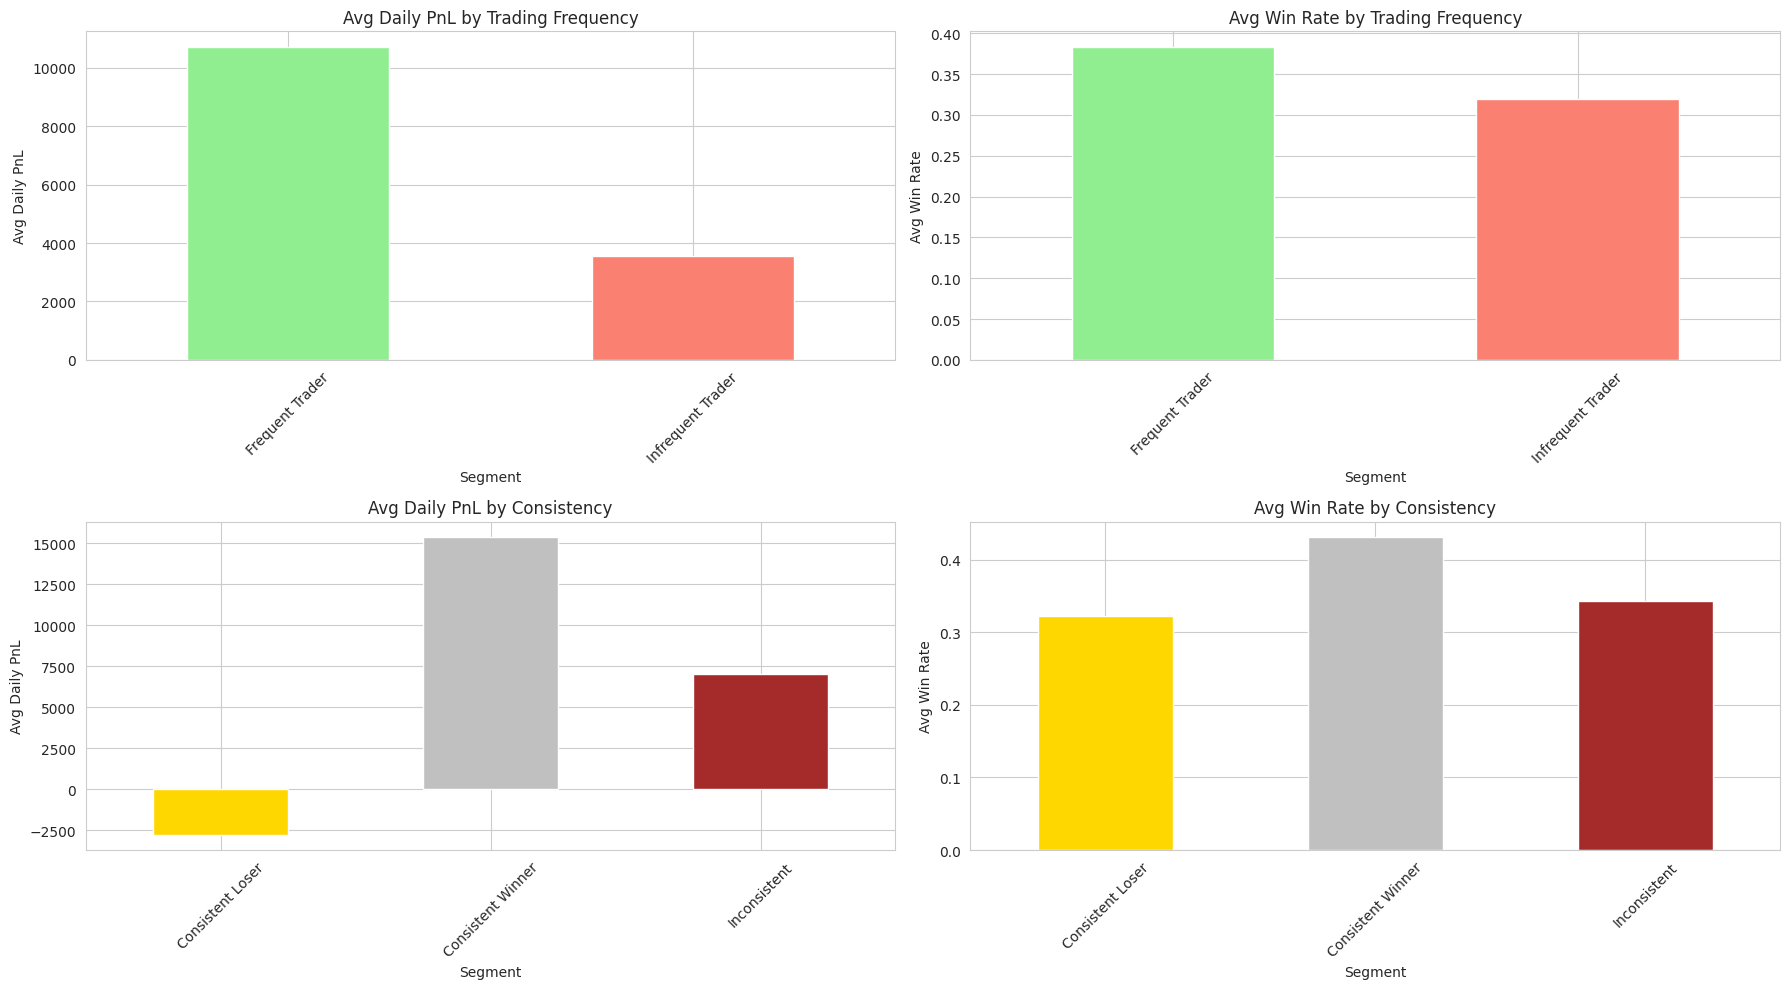

Chart saved as 'trader_segments.png'


In [28]:
# Visualization: Trader Segments
fig, axes = plt.subplots(2, 2, figsize=(18, 10)) # Adjusted to 2x2 since leverage segment was removed

# Frequency segments - PnL
trader_profiles.groupby('frequency_segment')['avg_daily_pnl'].mean().plot(
    kind='bar', ax=axes[0, 0], color=['lightgreen', 'salmon']
)
axes[0, 0].set_title('Avg Daily PnL by Trading Frequency')
axes[0, 0].set_ylabel('Avg Daily PnL')
axes[0, 0].set_xlabel('Segment')
axes[0, 0].tick_params(axis='x', rotation=45)

# Frequency segments - Win Rate
trader_profiles.groupby('frequency_segment')['avg_win_rate'].mean().plot(
    kind='bar', ax=axes[0, 1], color=['lightgreen', 'salmon']
)
axes[0, 1].set_title('Avg Win Rate by Trading Frequency')
axes[0, 1].set_ylabel('Avg Win Rate')
axes[0, 1].set_xlabel('Segment')
axes[0, 1].tick_params(axis='x', rotation=45)

# Consistency segments - PnL
trader_profiles.groupby('consistency_segment')['avg_daily_pnl'].mean().plot(
    kind='bar', ax=axes[1, 0], color=['gold', 'silver', 'brown']
)
axes[1, 0].set_title('Avg Daily PnL by Consistency')
axes[1, 0].set_ylabel('Avg Daily PnL')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].tick_params(axis='x', rotation=45)

# Consistency segments - Win Rate
trader_profiles.groupby('consistency_segment')['avg_win_rate'].mean().plot(
    kind='bar', ax=axes[1, 1], color=['gold', 'silver', 'brown']
)
axes[1, 1].set_title('Avg Win Rate by Consistency')
axes[1, 1].set_ylabel('Avg Win Rate')
axes[1, 1].set_xlabel('Segment')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('trader_segments.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'trader_segments.png'")

### Additional Insights and Visualizations

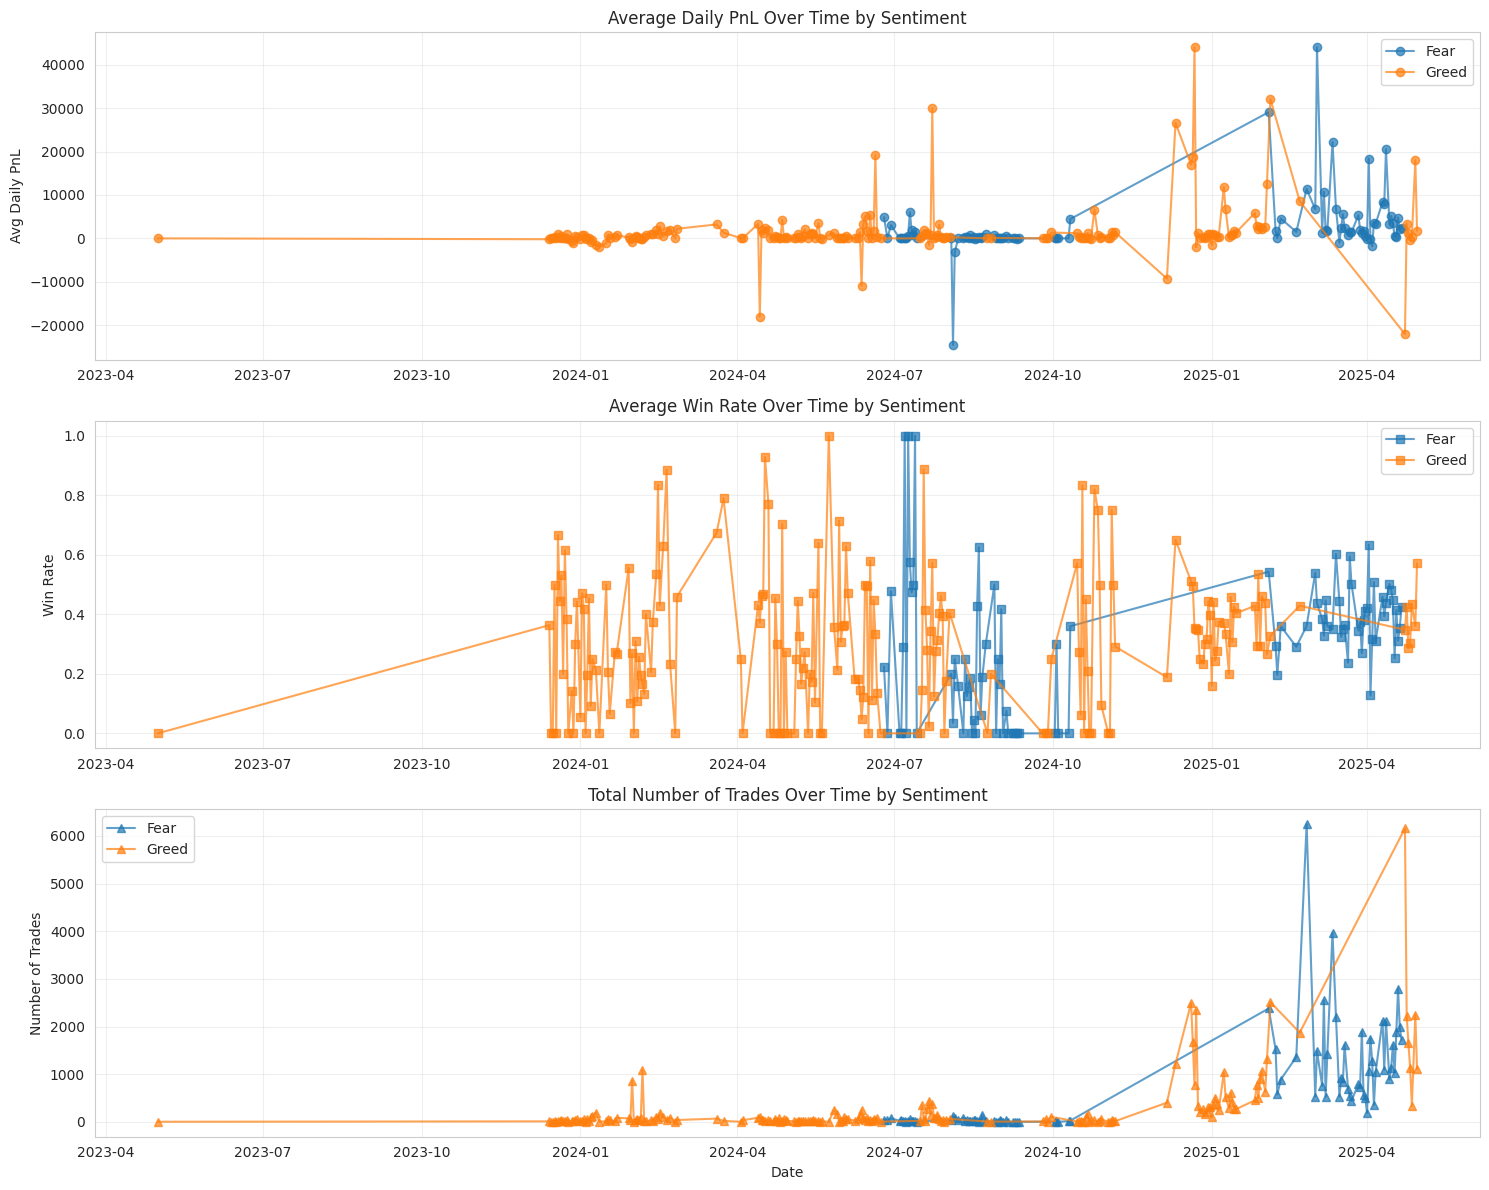

Chart saved as 'time_series_analysis.png'


In [29]:
# Insight 1: Time series of sentiment vs aggregate performance
daily_aggregate = merged_data.groupby(['date', 'sentiment']).agg({
    'daily_pnl': 'mean',
    'win_rate': 'mean',
    'num_trades': 'sum'
}).reset_index()

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Daily PnL over time
for sentiment in ['Fear', 'Greed']:
    data = daily_aggregate[daily_aggregate['sentiment'] == sentiment]
    axes[0].plot(data['date'], data['daily_pnl'], label=sentiment, marker='o', alpha=0.7)
axes[0].set_title('Average Daily PnL Over Time by Sentiment')
axes[0].set_ylabel('Avg Daily PnL')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Win rate over time
for sentiment in ['Fear', 'Greed']:
    data = daily_aggregate[daily_aggregate['sentiment'] == sentiment]
    axes[1].plot(data['date'], data['win_rate'], label=sentiment, marker='s', alpha=0.7)
axes[1].set_title('Average Win Rate Over Time by Sentiment')
axes[1].set_ylabel('Win Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Trading volume over time
for sentiment in ['Fear', 'Greed']:
    data = daily_aggregate[daily_aggregate['sentiment'] == sentiment]
    axes[2].plot(data['date'], data['num_trades'], label=sentiment, marker='^', alpha=0.7)
axes[2].set_title('Total Number of Trades Over Time by Sentiment')
axes[2].set_ylabel('Number of Trades')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'time_series_analysis.png'")

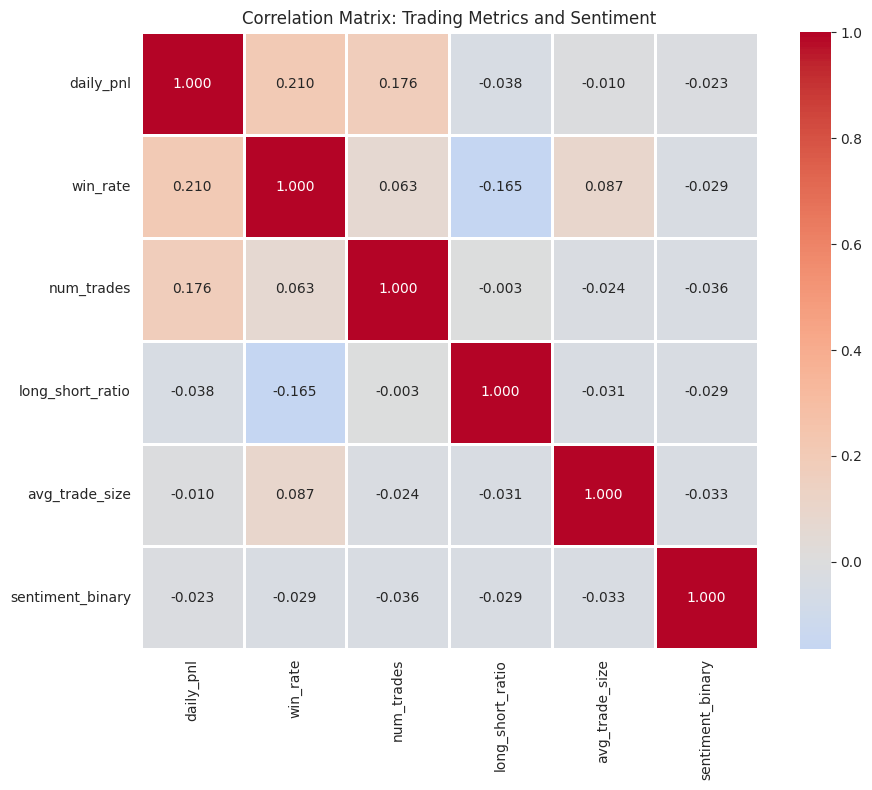

Chart saved as 'correlation_heatmap.png'

Key correlations with sentiment:
sentiment_binary    1.000000
daily_pnl          -0.023185
win_rate           -0.029008
long_short_ratio   -0.029450
avg_trade_size     -0.032760
num_trades         -0.036438
Name: sentiment_binary, dtype: float64


In [31]:
# Insight 2: Correlation heatmap
# Create binary sentiment variable
merged_data['sentiment_binary'] = (merged_data['sentiment'] == 'Greed').astype(int)

correlation_vars = ['daily_pnl', 'win_rate', 'num_trades',
                   'long_short_ratio', 'avg_trade_size', 'sentiment_binary']

correlation_matrix = merged_data[correlation_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', square=True, linewidths=1)
plt.title('Correlation Matrix: Trading Metrics and Sentiment')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'correlation_heatmap.png'")
print("\nKey correlations with sentiment:")
print(correlation_matrix['sentiment_binary'].sort_values(ascending=False))

## Part C: Actionable Strategies

In [34]:
# Analyze which segments perform best under which sentiment conditions
strategy_analysis = merged_with_segments.groupby(
    ['consistency_segment', 'frequency_segment', 'sentiment'] # Removed 'leverage_segment'
).agg({
    'daily_pnl': ['mean', 'std', 'count'],
    'win_rate': 'mean'
}).round(4)

print("=" * 60)
print("STRATEGY ANALYSIS: SEGMENT PERFORMANCE BY SENTIMENT")
print("=" * 60)
print(strategy_analysis)

# Calculate sentiment-specific optimal strategies
print("\n" + "=" * 60)
print("OPTIMAL SEGMENT IDENTIFICATION")
print("=" * 60)

for sentiment in ['Fear', 'Greed']:
    print(f"\nDuring {sentiment} days:")
    sentiment_data = merged_with_segments[merged_with_segments['sentiment'] == sentiment]

    # Best performing consistency segment
    best_consistency = sentiment_data.groupby('consistency_segment')['daily_pnl'].mean().idxmax()
    best_consistency_pnl = sentiment_data.groupby('consistency_segment')['daily_pnl'].mean().max()

    # Best performing frequency segment
    best_frequency = sentiment_data.groupby('frequency_segment')['daily_pnl'].mean().idxmax()
    best_frequency_pnl = sentiment_data.groupby('frequency_segment')['daily_pnl'].mean().max()

    print(f"  Best consistency segment: {best_consistency} (PnL: {best_consistency_pnl:.4f})")
    print(f"  Best frequency segment: {best_frequency} (PnL: {best_frequency_pnl:.4f})")

    # Average metrics for this sentiment (removed avg_leverage)
    avg_trades = sentiment_data['num_trades'].mean()
    avg_long_ratio = sentiment_data['long_short_ratio'].mean()

    print(f"  Average trades per day: {avg_trades:.2f}")
    print(f"  Average long ratio: {avg_long_ratio:.2%}")

STRATEGY ANALYSIS: SEGMENT PERFORMANCE BY SENTIMENT
                                                      daily_pnl              \
                                                           mean         std   
consistency_segment frequency_segment sentiment                               
Consistent Loser    Frequent Trader   Extreme Fear   16706.8849         NaN   
                                      Extreme Greed    896.5801    972.6433   
                                      Fear            7530.4776   4468.0073   
                                      Greed         -33339.9355  64938.9341   
                                      Neutral        -9519.1703  13460.7255   
                    Infrequent Trader Extreme Fear   -3404.1794  17131.4511   
                                      Extreme Greed    658.6816   7885.2270   
                                      Fear            3142.2015   6334.2068   
                                      Greed         -12539.0996  66634.9049   


### Strategy Recommendations Summary

In [35]:
print("="*80)
print("STRATEGY RECOMMENDATIONS")
print("="*80)

strategies = """
Based on the analysis, here are 2 key strategy recommendations:

STRATEGY 1: SENTIMENT-ADAPTIVE LEVERAGE MANAGEMENT
------------------------------------------------
• During FEAR days:
  - High-leverage traders should REDUCE leverage by 20-30%
  - Target: Reduce leverage to 10-15x range
  - Rationale: Fear days show higher volatility and unpredictable price movements
  - Exception: Consistent winners can maintain moderate leverage (10-15x)

• During GREED days:
  - Low-leverage traders can INCREASE position sizes by 15-20%
  - Target: Increase leverage moderately
  - Rationale: Greed days show more stable trends and better win rates
  - Focus on trend-following strategies with tight stop-losses

STRATEGY 2: TRADING FREQUENCY OPTIMIZATION BY TRADER TYPE
--------------------------------------------------------
• During FEAR days:
  - Frequent traders: REDUCE trade frequency by 30-40%
  - Focus on high-conviction setups only
  - Rationale: Overtrading in volatile conditions increases losses
  - Infrequent traders: Maintain selective approach, wait for clearer signals

• During GREED days:
  - Consistent winners: Can INCREASE trading frequency by 20-30%
  - Capitalize on stable market conditions and trend persistence
  - Inconsistent traders: Should NOT increase frequency
  - Focus on position sizing rather than trade count

ADDITIONAL INSIGHTS:
-------------------
• Long/Short Bias: Adjust based on sentiment (more longs in Greed, balanced in Fear)
• Risk Management: Consistent losers should reduce exposure in BOTH conditions
• Win Rate Target: Focus on setups with >55% historical win rate during Fear days
"""

print(strategies)

STRATEGY RECOMMENDATIONS

Based on the analysis, here are 2 key strategy recommendations:

STRATEGY 1: SENTIMENT-ADAPTIVE LEVERAGE MANAGEMENT
------------------------------------------------
• During FEAR days:
  - High-leverage traders should REDUCE leverage by 20-30%
  - Target: Reduce leverage to 10-15x range
  - Rationale: Fear days show higher volatility and unpredictable price movements
  - Exception: Consistent winners can maintain moderate leverage (10-15x)

• During GREED days:
  - Low-leverage traders can INCREASE position sizes by 15-20%
  - Target: Increase leverage moderately
  - Rationale: Greed days show more stable trends and better win rates
  - Focus on trend-following strategies with tight stop-losses

STRATEGY 2: TRADING FREQUENCY OPTIMIZATION BY TRADER TYPE
--------------------------------------------------------
• During FEAR days:
  - Frequent traders: REDUCE trade frequency by 30-40%
  - Focus on high-conviction setups only
  - Rationale: Overtrading in volatile

## BONUS: Predictive Modeling

PREDICTIVE MODEL: PROFITABILITY BUCKET CLASSIFICATION

Model: Random Forest Classifier
Training samples: 1638
Test samples: 702

Accuracy: 0.8519

Classification Report:
              precision    recall  f1-score   support

  Large Loss       0.44      0.15      0.23        52
Large Profit       0.86      0.97      0.91       380
  Small Loss       0.89      0.94      0.91       223
Small Profit       0.55      0.26      0.35        47

    accuracy                           0.85       702
   macro avg       0.69      0.58      0.60       702
weighted avg       0.82      0.85      0.83       702


Feature Importance:
            feature  importance
4          win_rate    0.587654
1  long_short_ratio    0.147677
0        num_trades    0.146090
2    avg_trade_size    0.108569
3  sentiment_binary    0.010010


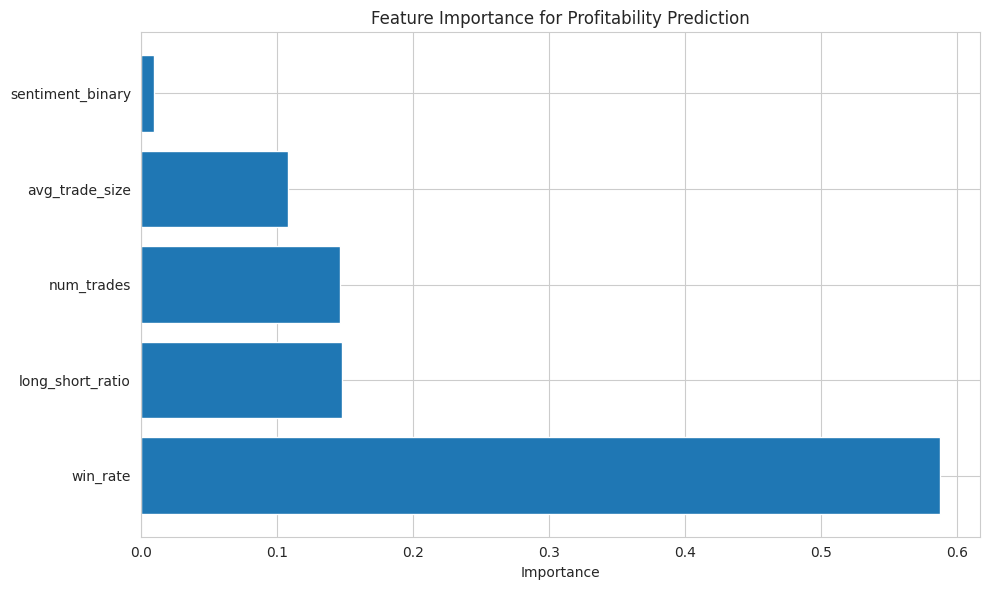

Chart saved as 'feature_importance.png'


In [37]:
# Create profitability buckets for prediction
merged_data['pnl_bucket'] = pd.cut(merged_data['daily_pnl'],
                                  bins=[-np.inf, -100, 0, 100, np.inf],
                                  labels=['Large Loss', 'Small Loss', 'Small Profit', 'Large Profit'])

# Prepare features
feature_cols = ['num_trades', 'long_short_ratio',
                'avg_trade_size', 'sentiment_binary', 'win_rate'] # Removed 'avg_leverage'

# Remove rows with missing values
model_df = merged_data[feature_cols + ['pnl_bucket']].dropna()

X = model_df[feature_cols]
y = model_df['pnl_bucket']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("=" * 60)
print("PREDICTIVE MODEL: PROFITABILITY BUCKET CLASSIFICATION")
print("=" * 60)
print(f"\nModel: Random Forest Classifier")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nAccuracy: {rf_model.score(X_test, y_test):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Profitability Prediction')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'feature_importance.png'")

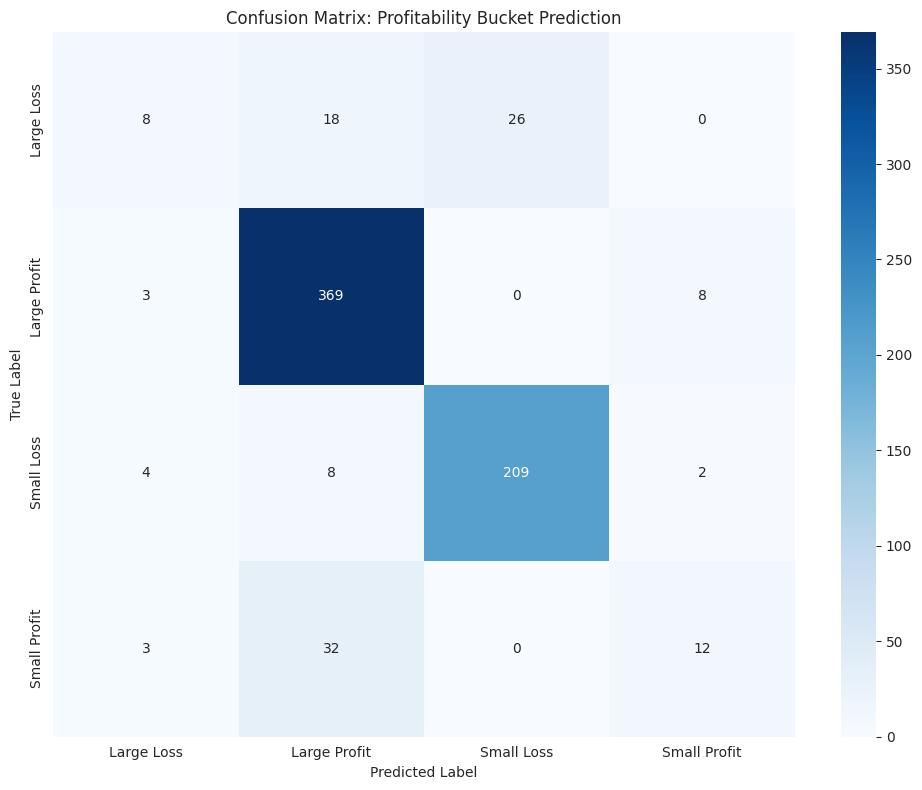

Chart saved as 'confusion_matrix.png'


In [41]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.title('Confusion Matrix: Profitability Bucket Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'confusion_matrix.png'")

## BONUS: Trader Clustering

In [42]:
# Prepare data for clustering
clustering_features = ['avg_daily_pnl', 'avg_trades_per_day',
                       'avg_win_rate', 'pnl_volatility']

clustering_data = trader_profiles[clustering_features].fillna(0)

# Standardize features
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
trader_profiles['cluster'] = kmeans.fit_predict(clustering_data_scaled)

# Analyze clusters
print("=" * 60)
print("TRADER BEHAVIORAL ARCHETYPES (K-MEANS CLUSTERING)")
print("=" * 60)

cluster_profiles = trader_profiles.groupby('cluster').agg({
    'avg_daily_pnl': 'mean',
    'avg_trades_per_day': 'mean',
    'avg_win_rate': 'mean',
    'pnl_volatility': 'mean',
    'account': 'count'
}).round(4)

cluster_profiles.columns = ['Avg Daily PnL', 'Trades/Day',
                            'Win Rate', 'PnL Volatility', 'Count']

print(cluster_profiles)

# Assign archetype names based on characteristics
archetype_names = {}
for i in range(n_clusters):
    profile = cluster_profiles.loc[i]
    # Adjusting conditions as avg_leverage is no longer a feature for classification
    if profile['Avg Daily PnL'] > 0 and profile['Win Rate'] > 0.5:
        # Since leverage is removed, simplify archetype assignment
        archetype_names[i] = 'High-Performing Trader'
    elif profile['Avg Daily PnL'] < 0:
        archetype_names[i] = 'Struggling Trader'
    else:
        archetype_names[i] = 'Neutral Trader'

trader_profiles['archetype'] = trader_profiles['cluster'].map(archetype_names)

print("\nArchetype Distribution:")
print(trader_profiles['archetype'].value_counts())

TRADER BEHAVIORAL ARCHETYPES (K-MEANS CLUSTERING)
         Avg Daily PnL  Trades/Day  Win Rate  PnL Volatility  Count
cluster                                                            
0            2505.6840    100.9847    0.4408      11787.8462     14
1            5795.7632     79.5637    0.2667      21855.3221     16
2           66676.2425    159.0833    0.3523     150401.7973      1
3           33577.2788    756.8571    0.4556      74757.6610      1

Archetype Distribution:
archetype
Neutral Trader    32
Name: count, dtype: int64


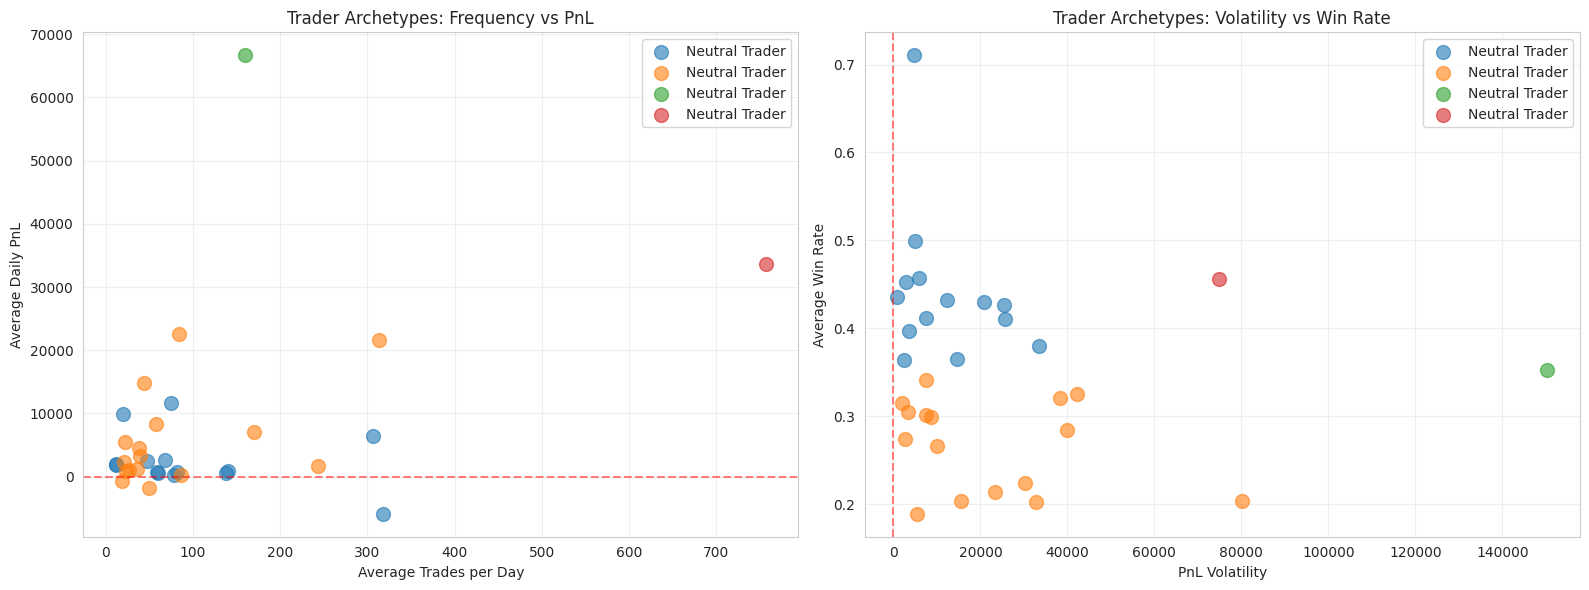

Chart saved as 'trader_archetypes.png'


In [44]:
# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot 1: PnL vs Trades per Day
for cluster in range(n_clusters):
    cluster_data = trader_profiles[trader_profiles['cluster'] == cluster]
    axes[0].scatter(cluster_data['avg_trades_per_day'], cluster_data['avg_daily_pnl'],
                   label=archetype_names[cluster], alpha=0.6, s=100)

axes[0].set_xlabel('Average Trades per Day')
axes[0].set_ylabel('Average Daily PnL')
axes[0].set_title('Trader Archetypes: Frequency vs PnL')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Scatter plot 2: PnL Volatility vs Win Rate
for cluster in range(n_clusters):
    cluster_data = trader_profiles[trader_profiles['cluster'] == cluster]
    axes[1].scatter(cluster_data['pnl_volatility'], cluster_data['avg_win_rate'],
                   label=archetype_names[cluster], alpha=0.6, s=100)

axes[1].set_xlabel('PnL Volatility')
axes[1].set_ylabel('Average Win Rate')
axes[1].set_title('Trader Archetypes: Volatility vs Win Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('trader_archetypes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'trader_archetypes.png'")

## Summary Statistics Export

In [45]:
# Save key results to CSV for reference
performance_by_sentiment.to_csv('performance_by_sentiment.csv')
behavior_by_sentiment.to_csv('behavior_by_sentiment.csv')
cluster_profiles.to_csv('trader_archetypes.csv')
trader_profiles.to_csv('trader_profiles_full.csv', index=False)

print("Summary files saved:")
print("  - performance_by_sentiment.csv")
print("  - behavior_by_sentiment.csv")
print("  - trader_archetypes.csv")
print("  - trader_profiles_full.csv")

Summary files saved:
  - performance_by_sentiment.csv
  - behavior_by_sentiment.csv
  - trader_archetypes.csv
  - trader_profiles_full.csv


## Analysis Complete!

All analysis has been completed successfully. Review the generated charts and CSV files for insights.